# AnSeqData Project

### Nanchen Jean - Zimmermann Thomas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# Open dataset with column names as in gridwatch.csv
df = pd.read_csv('gridwatch.csv', header=0, delimiter=",", names=['timestamp', 'demand', 'frequency', 'coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar'])

# Keep only timestamp and coal columns
df = df[['timestamp', 'coal']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.shape)
df.head()


(796453, 2)


,timestamp,coal
62694,2012-01-01 00:00:01,8693
62695,2012-01-01 00:05:06,8650
62696,2012-01-01 00:10:01,8880
62697,2012-01-01 00:15:01,9111
62698,2012-01-01 00:20:01,9195


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

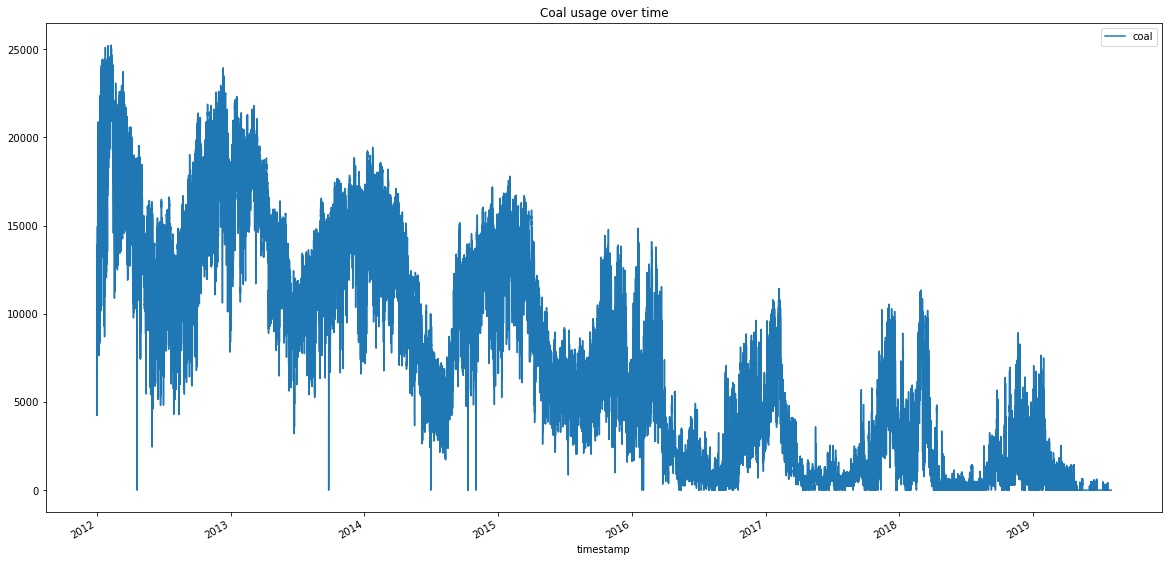

In [3]:
# Plot the coal usage column over time 
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')


Saisonalité -> usage intesif en hiver, beaucoup moins en été. Tendance à la baisse overall

In [4]:
# Pre-process coal data to get the average coal usage per day
dfDay = df
dfDay = dfDay.set_index('timestamp')
dfDay = dfDay.resample('D').mean()
dfDay = dfDay.reset_index()
print(dfDay.shape)
dfDay.head()

(2772, 2)


,timestamp,coal
0,2012-01-01,8501.128472
1,2012-01-02,10203.655052
2,2012-01-03,15384.989583
3,2012-01-04,17026.888889
4,2012-01-05,16545.250000


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

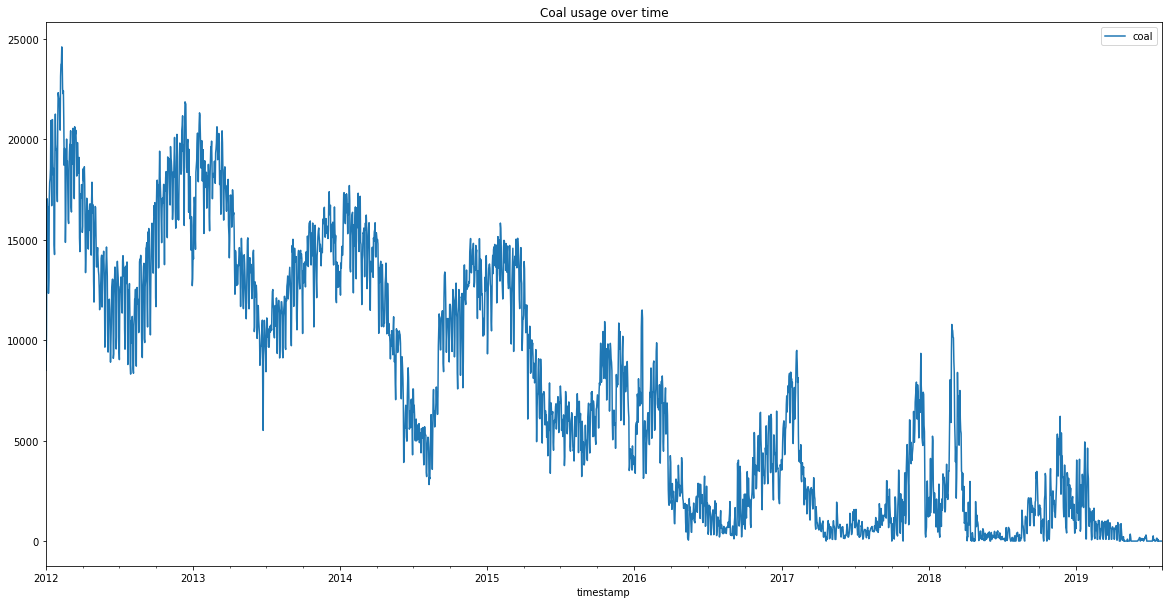

In [5]:
dfDay.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')

On s'assure qu'on perd pas d'infos importantes en moyennant par jour

<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

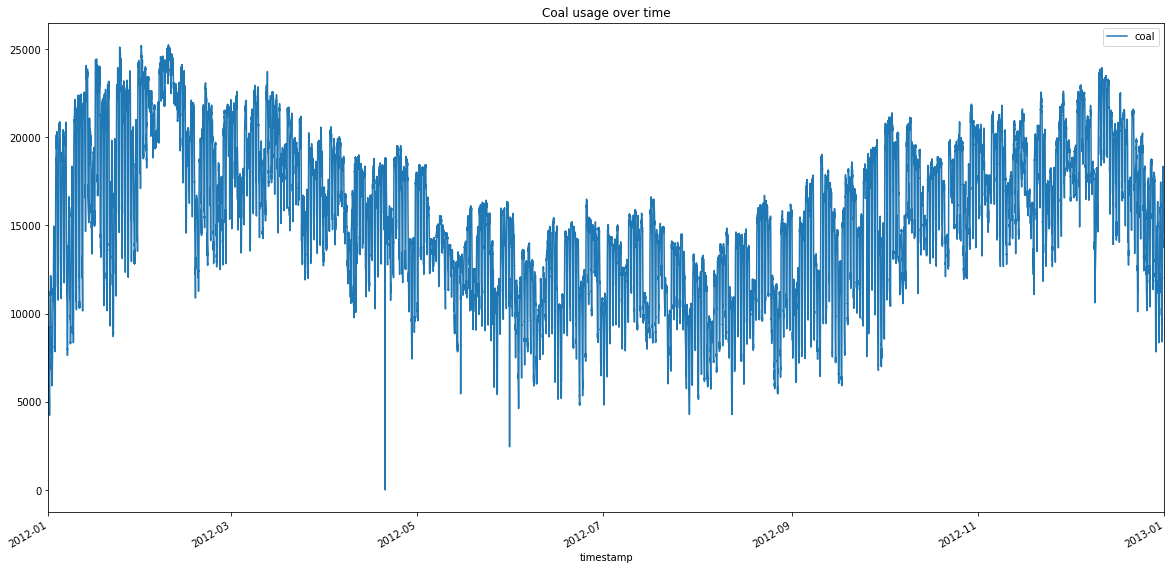

In [6]:
# Plot the first year of coal usage
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time', xlim=['2012-01-01', '2013-01-01'])

On voit qu'il y a aussi une saisonaité journalière -> zoom sur ca

<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

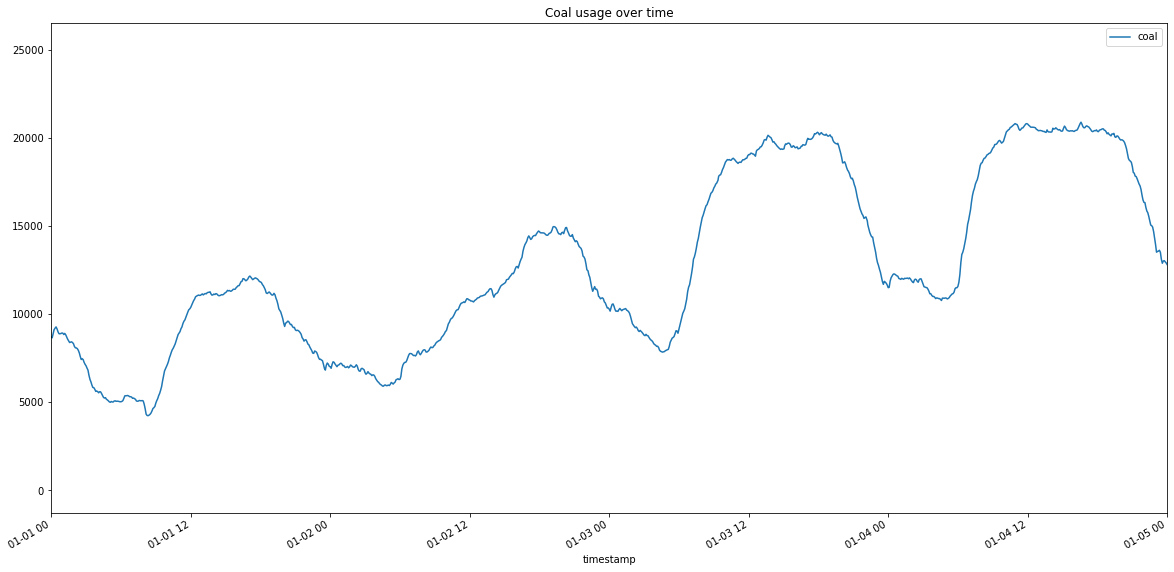

In [7]:
# Plot the first month of coal usage vs hour of day
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time', xlim=['2012-01-01', '2012-01-05'])


Sympa de remarquer mais surement pas très important pour l'analyse parce qu'on analyse sur des + longues périodes -> La saisonalité annuelle est plus intéressante que la saisonalité journalière, a partir d'ici pour les analyses on utilise dfDay plutot que df

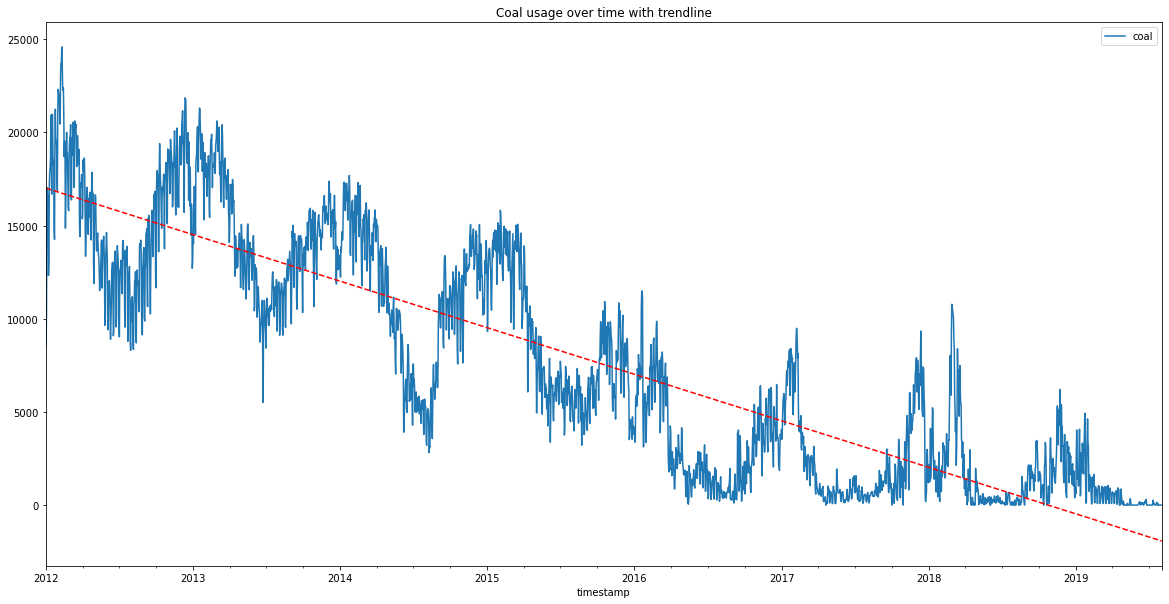

In [8]:
# Generate trendline for coal usage over time
# calc the trendline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
x = mdates.date2num(dfDay['timestamp'])
y= dfDay['coal']
z = np.polyfit(x, dfDay['coal'], 1)
p = np.poly1d(z)
#then the plot
dfDay.plot('timestamp', 'coal', figsize=(20, 10), title='Coal usage over time with trendline')
plt.plot(x, p(x), "r--")



La trendline nous indique clairement une tendance baissière (qu'on appercevait déjà à l'oeil nu mais là au moins c'est officiel)

# Cropping dataset

(1461, 2)
(1311, 2)


<ipython-input-9-65bb466a2974>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


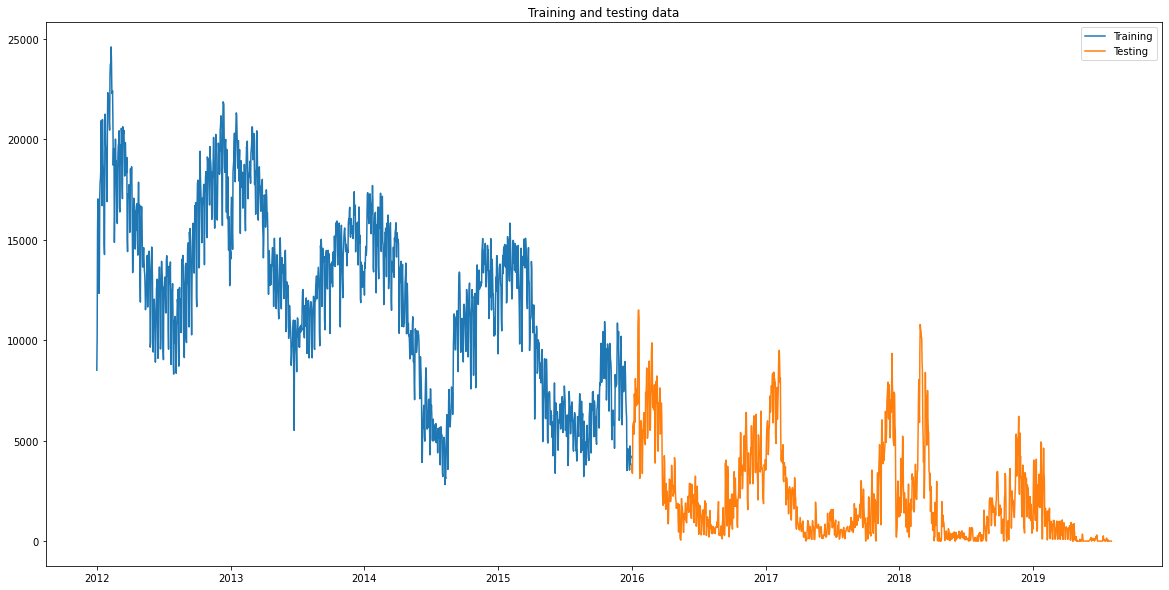

In [9]:
# Separate the dfDay dataframe into two dataframes, one for training and one for testing
dfDayTrain = dfDay[dfDay['timestamp'] < '2016-01-01']
dfDayTest = dfDay[dfDay['timestamp'] >= '2016-01-01']
print(dfDayTrain.shape)
print(dfDayTest.shape)

# Plot the training and testing dataframes with matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()

c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-10-ad5de0ae8eaa>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


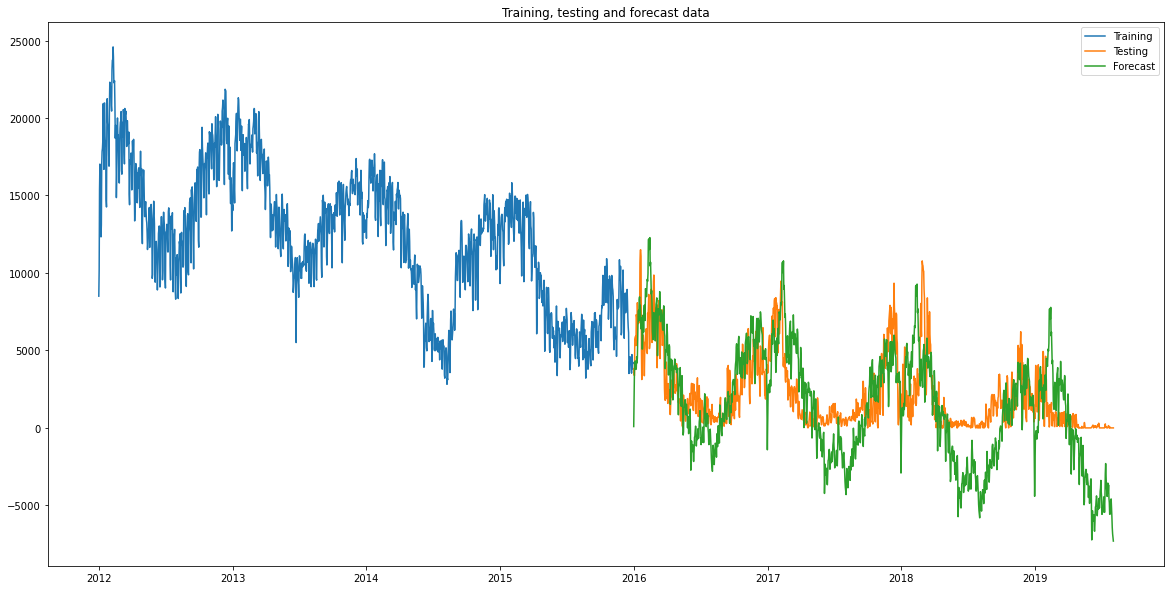

In [10]:
# We want to forecast the coal usage for the next days based on the length of the testing dataframe

from statsmodels.tsa.api import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(dfDayTrain['coal'], seasonal_periods=365, trend='add', seasonal='add').fit(optimized=True)

# Forecast the next days based on the length of the testing dataframe
forecast = model.forecast(len(dfDayTest))

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()




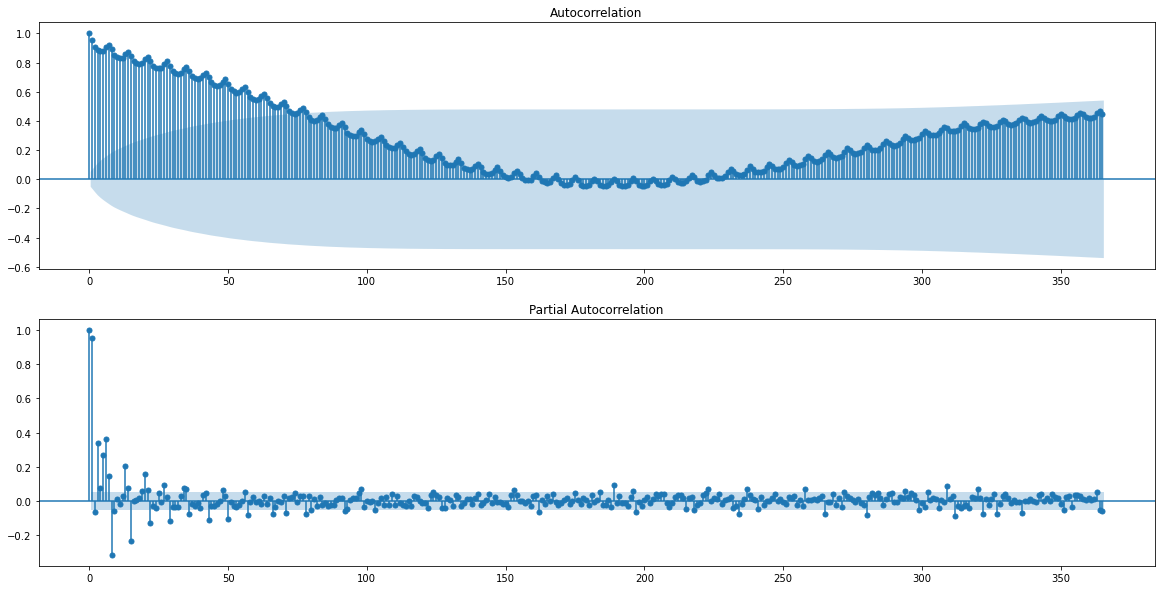

In [11]:
# Do a ACF and PACF plot to determine the order of the ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Make two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
# Plot the ACF
plot_acf(dfDayTrain['coal'], lags=365, ax=ax1)
# Plot the PACF
plot_pacf(dfDayTrain['coal'], lags=365, ax=ax2)
plt.show()



On remarque que ce n'est pas stationnaire, on a une tendance vers le bas... On peut le savoir car ici en bas je calcule le p-value et si = 0 = stationnaire

In [12]:
# Test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfDayTrain['coal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -1.554461
p-value: 0.506419
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [13]:
# Diff and dropna to make the data stationary
dfDayTrainDiff = dfDayTrain.copy()
dfDayTrainDiff["coal"] = dfDayTrainDiff["coal"].diff().dropna()
dfDayTrainDiff.head()
# Drop NaN values
dfDayTrainDiff = dfDayTrainDiff.dropna()
dfDayTrainDiff.head()
print(dfDayTrainDiff.shape)


(1460, 2)


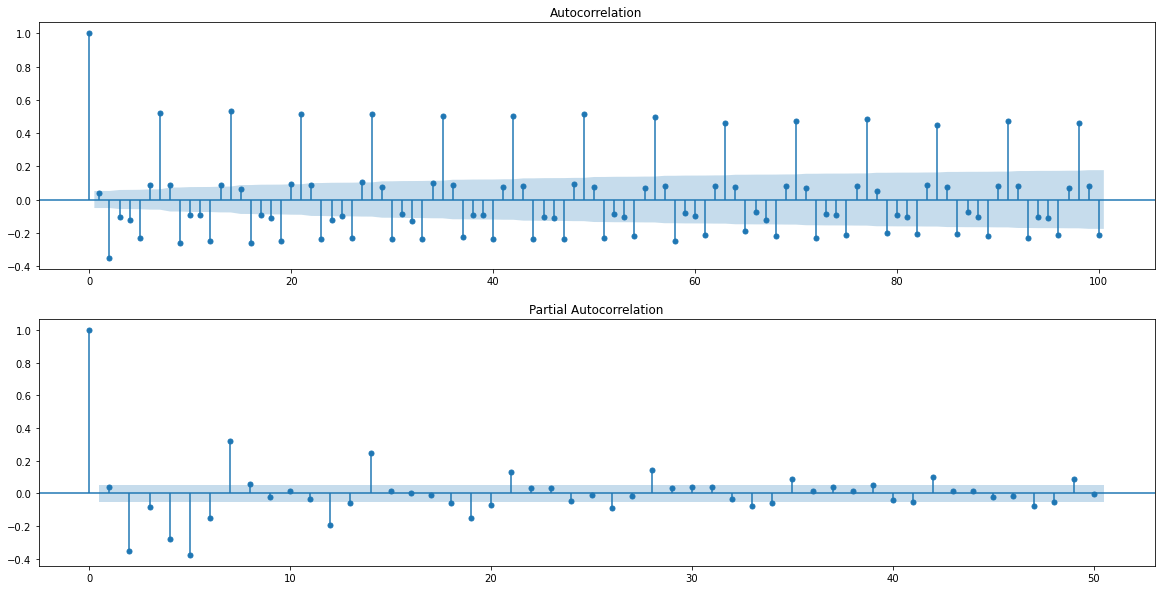

ADF Statistic: -9.580115
p-value: 0.000000


In [14]:
# Replot the ACF and PACF to determine the order of the ARIMA model
# Make two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
# Plot the ACF
plot_acf(dfDayTrainDiff["coal"], lags=100, ax=ax1)
# Plot the PACF
plot_pacf(dfDayTrainDiff["coal"], lags=50, ax=ax2)
plt.show()

# Test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfDayTrainDiff["coal"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


### On voit sur le plot du haut que pour le PACF on devient dans la plage vers la 25ème et pour le ACF vers 400 ducoup j'ai déterminé p = 25 et q = 365

In [15]:
# Function to calculate the MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)



                               SARIMAX Results                                
Dep. Variable:                   coal   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12484.613
Date:                Fri, 09 Dec 2022   AIC                          24975.225
Time:                        18:01:06   BIC                          24991.084
Sample:                             0   HQIC                         24981.141
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6025      0.032     18.838      0.000       0.540       0.665
ma.L1         -0.8736      0.022    -40.255      0.000      -0.916      -0.831
sigma2      1.707e+06   5.59e+04     30.540      0.0

<ipython-input-16-b6e417f5d385>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


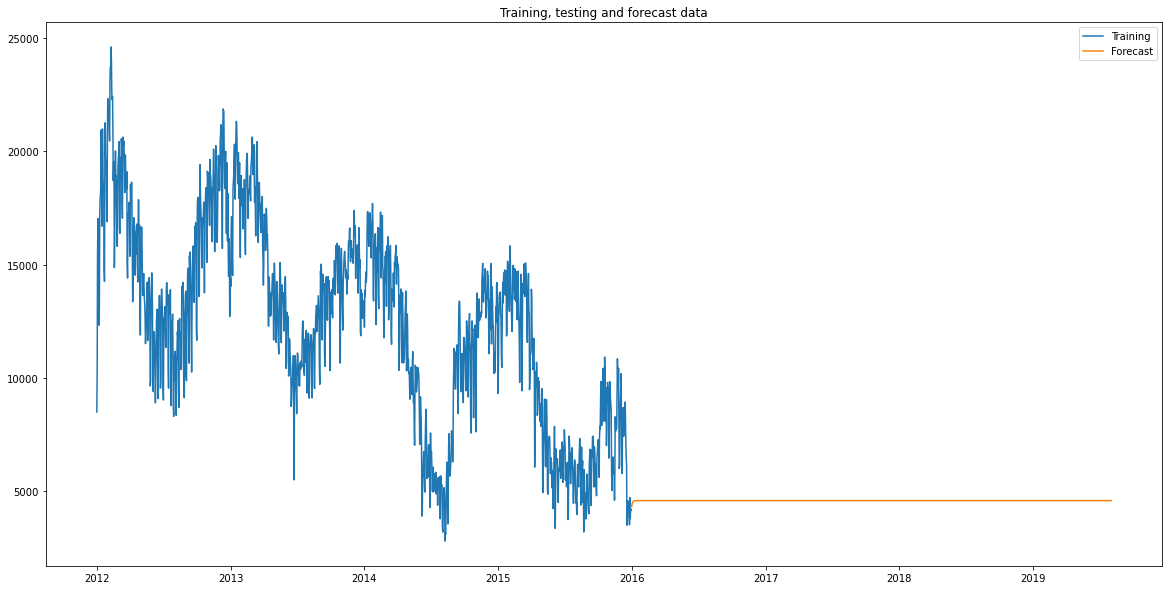

In [16]:
# Forecast the next days based on the length of the testing dataframe with ARMIA model
# Auto determine the order of the model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dfDayTrain['coal'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next days based on the length of the testing dataframe
forecast = model_fit.forecast(steps=len(dfDayTest))



#Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()

# Calculate the MSE
print(mean_squared_error(dfDayTest['coal'], forecast))


<ipython-input-19-bfbaf2fe1071>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


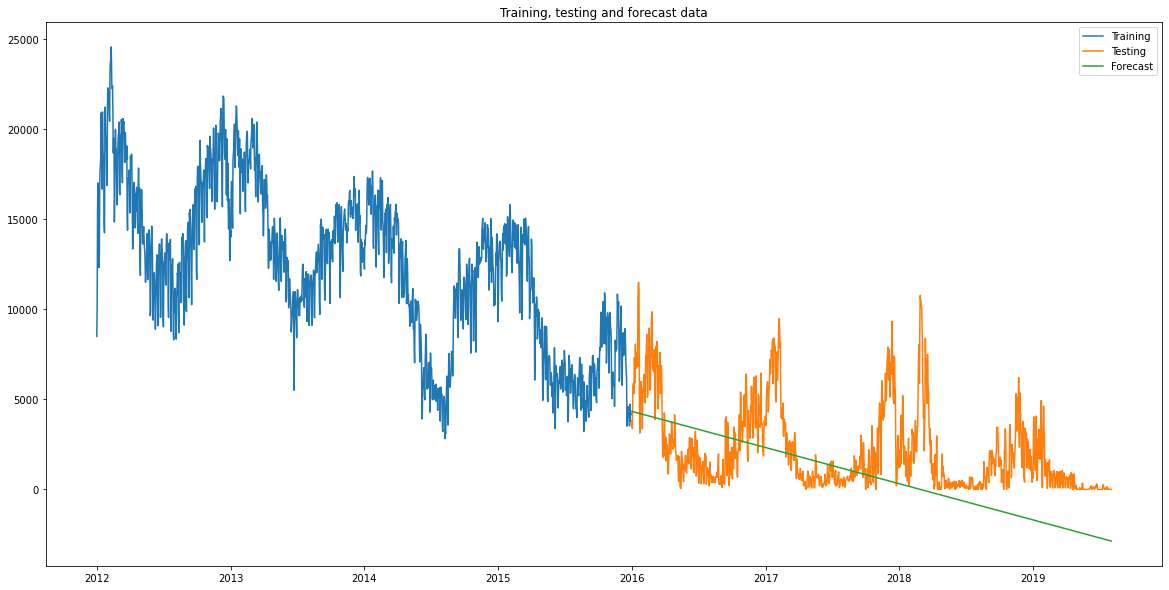

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create ARMIA model with the order (1, 1, 1) with the training data and forecast the next days based on the length of the testing dataframe
model = SARIMAX(dfDayTrain["coal"], order=(0, 2, 4))
model_fit = model.fit()
forecast = model_fit.forecast(len(dfDayTest))

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()



In [20]:
# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create function who test different orders of the SARIMAX model, compare the MSE and return the best order
def evaluate_arima_model(X, arima_order):

    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    # make predictions
    # We have a seasonal component of 365 days, so we use the seasonal_order parameter
    model = SARIMAX(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))

    # calculate out of sample error
    error = mean_squared_error(test, forecast)
    return error
    
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# Evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

evaluate_models(dfDay['coal'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=7584136.092


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) MSE=7559919.051
ARIMA(0, 0, 2) MSE=7544666.307
ARIMA(0, 0, 3) MSE=7519718.873
ARIMA(0, 0, 4) MSE=7510357.059
ARIMA(0, 1, 0) MSE=9644245.794
ARIMA(0, 1, 1) MSE=9888855.746
ARIMA(0, 1, 2) MSE=8546315.950
ARIMA(0, 1, 3) MSE=8409014.152
ARIMA(0, 1, 4) MSE=8408160.731
ARIMA(0, 2, 0) MSE=57107472342.344
ARIMA(0, 2, 1) MSE=10650970.231
ARIMA(0, 2, 2) MSE=11383919.225
ARIMA(0, 2, 3) MSE=4275532.118
ARIMA(0, 2, 4) MSE=4224692.290
ARIMA(1, 0, 0) MSE=5161170.196
ARIMA(1, 0, 1) MSE=5358775.591
ARIMA(1, 0, 2) MSE=5137997.128
ARIMA(1, 0, 3) MSE=8273540.401
ARIMA(1, 0, 4) MSE=5346881.113
ARIMA(1, 1, 0) MSE=9726439.123
ARIMA(1, 1, 1) MSE=8416026.367
ARIMA(1, 1, 2) MSE=8415528.530
ARIMA(1, 1, 3) MSE=8408804.906
ARIMA(1, 1, 4) MSE=8711754.955
ARIMA(1, 2, 0) MSE=13575695700.807
ARIMA(1, 2, 1) MSE=10969997.515
ARIMA(1, 2, 2) MSE=11374232.927
ARIMA(1, 2, 3) MSE=4229184.616
ARIMA(1, 2, 4) MSE=4276497.688
ARIMA(2, 0, 0) MSE=5214235.575


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 1) MSE=5282490.084
ARIMA(2, 0, 2) MSE=5431133.314
ARIMA(2, 0, 3) MSE=4728076.704


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 4) MSE=5050726.275
ARIMA(2, 1, 0) MSE=9827578.621
ARIMA(2, 1, 1) MSE=8420518.273
ARIMA(2, 1, 2) MSE=8413674.330
ARIMA(2, 1, 3) MSE=9980383.466


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4) MSE=9196703.077
ARIMA(2, 2, 0) MSE=16105090585.011
ARIMA(2, 2, 1) MSE=8057448.509
ARIMA(2, 2, 2) MSE=4228855.423
ARIMA(2, 2, 3) MSE=10896459.440
ARIMA(2, 2, 4) MSE=11765805.275
ARIMA(3, 0, 0) MSE=4458299.084


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1) MSE=5389199.062


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) MSE=8367978.644


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) MSE=9729073.890


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 4) MSE=9036833.126
ARIMA(3, 1, 0) MSE=9640391.835
ARIMA(3, 1, 1) MSE=8419489.865


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2) MSE=8453371.307


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) MSE=10484458.186


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4) MSE=9609891.075
ARIMA(3, 2, 0) MSE=9923176857.148
ARIMA(3, 2, 1) MSE=7305289.508
ARIMA(3, 2, 2) MSE=8252771.534


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 3) MSE=9156133.232


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 2, 4) MSE=8992718.680
ARIMA(4, 0, 0) MSE=4323409.444


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 1) MSE=5144658.102


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 2) MSE=9294078.284
ARIMA(4, 0, 3) MSE=9685603.963


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 4) MSE=9406157.699
ARIMA(4, 1, 0) MSE=9426940.058
ARIMA(4, 1, 1) MSE=8749675.873


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2) MSE=10447064.869


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 3) MSE=10431031.740


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 4) MSE=8374508.989
ARIMA(4, 2, 0) MSE=7170005248.228
ARIMA(4, 2, 1) MSE=5532052.209


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 2) MSE=4310080.290


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 2, 3) MSE=7777260.185
ARIMA(4, 2, 4) MSE=9542945.551
Best ARIMA(0, 2, 4) MSE=4224692.290


c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<ipython-input-31-a1798736418d>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-31-a1798736418d>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


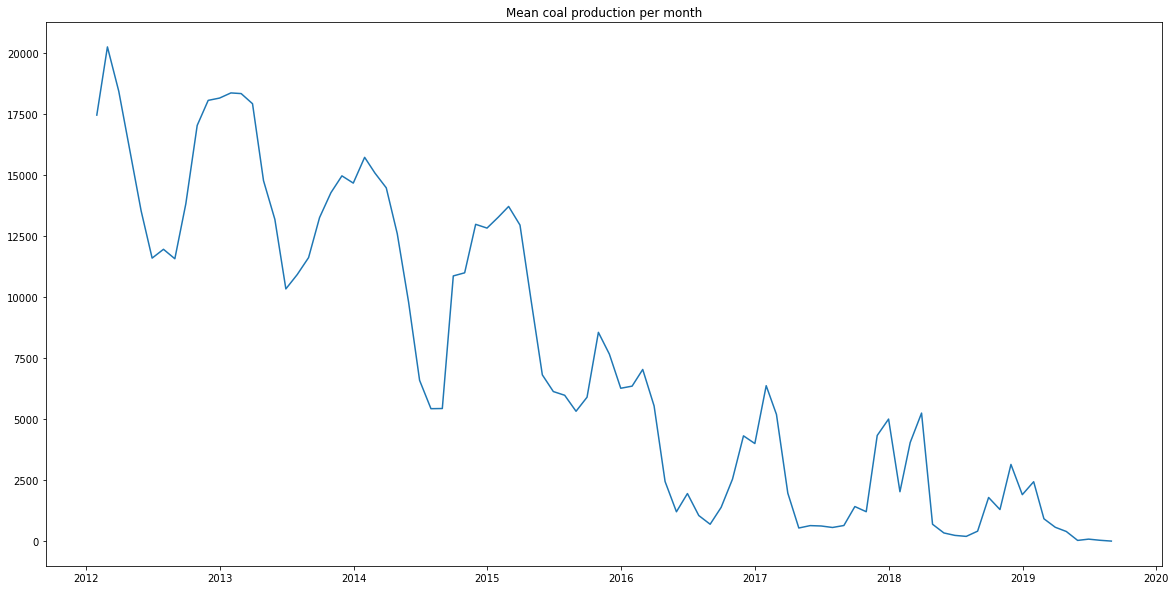

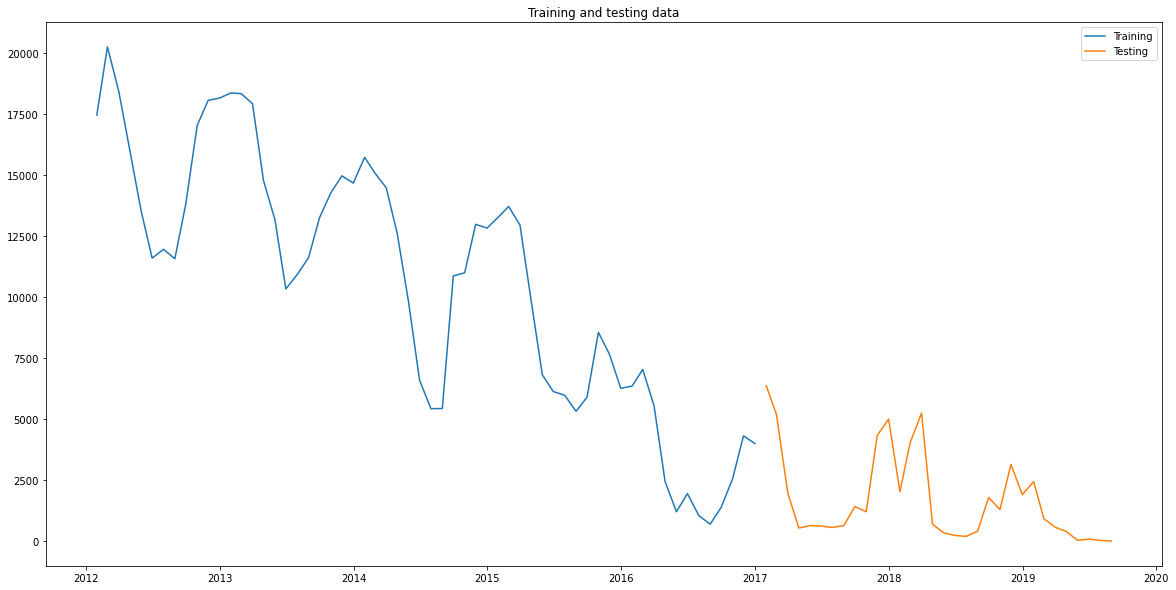

In [31]:
# Create a reduced dataframe with only the timestamp and the coal column
dfMonth = dfDay[['timestamp', 'coal']].copy()

# Mean of the coal column per month
dfMonth = dfMonth.groupby(pd.Grouper(key='timestamp', freq='M')).mean()
dfMonth.head()

# Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonth.index, dfMonth['coal'])
ax.set_title('Mean coal production per month')
fig.show()

# Split the data in training and testing data
dfMonthTrain = dfMonth[:'2016-12-31']
dfMonthTest = dfMonth['2017-01-31':]

# Plot the training and testing data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()



c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               coal   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -405.620
Date:                            Fri, 09 Dec 2022   AIC                            821.239
Time:                                    18:07:47   BIC                            830.490
Sample:                                01-31-2012   HQIC                           824.720
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9285      0.356     -2.607      0.009      -1.626      -0.231
ma.L1          0.9716      0.499   

<ipython-input-32-2aedb85cd095>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


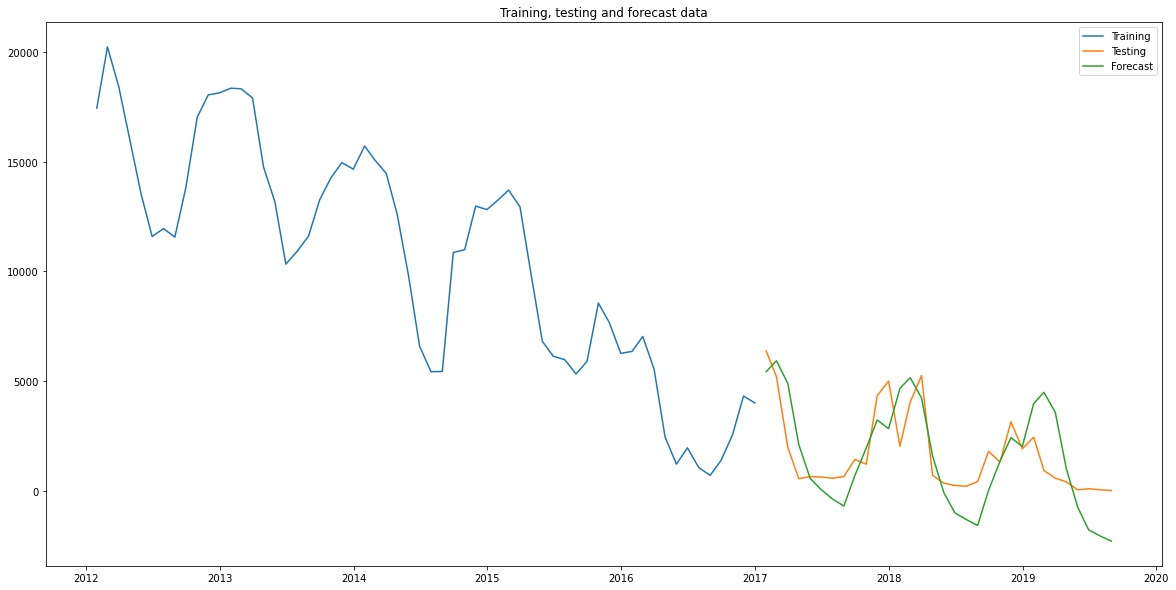

In [32]:
# SARIMAX model with the order (1, 1, 1) and seasonal order (1, 1, 1, 12)
model = SARIMAX(dfMonthTrain['coal'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next months based on the length of the testing dataframe
forecast = model_fit.forecast(len(dfMonthTest))

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.plot(dfMonthTest.index, forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()



